<a href="https://colab.research.google.com/github/Kieranosaurus/HYPER/blob/master/MXNet_PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mxnet
!pip install mxnet-cu101

import mxnet as mx
from mxnet import nd, gluon, init, autograd, gpu
from mxnet.gluon import nn
from mxnet.gluon.data.vision import datasets, transforms
from IPython import display
import matplotlib.pyplot as plt
import time
import numpy as np
import pickle
from PIL import Image
import matplotlib.image as mpimg
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!cp '/content/drive/MyDrive/Bachelor Thesis/HYPER/data_sub1_4096.dat' '/content/'
!cp '/content/drive/MyDrive/Bachelor Thesis/HYPER/pggan_weights' '/content/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# def load_weights(net):
#     with open('pggan_weights', 'rb') as f:
#         wb = pickle.load(f)

#     weights = []
#     biases = []
#     for i in range(110, 163, 6):
#         weights.append(wb[i])
#         biases.append(wb[i+1])
#         weights.append(wb[i+2])
#         biases.append(wb[i+3])
#     weights.append(wb[162])
#     biases.append(wb[163])
    
#     names_biases = []
#     for i in range(19):
#         names_biases.append("net0_apply_bias"+str(i)+"_b")
    
#     names_weights = []
#     names_weights.append("net0_dense0_weight")
#     for i in range(18):
#         names_weights.append("net0_conv"+str(i)+"_weight")

#     for i in range(len(weights)):
#         weights[i] = weights[i].astype('float32') #* scalars[i]
#         net.collect_params()[names_weights[i]].set_data(nd.transpose(nd.array(weights[i])))
#         net.collect_params()[names_biases[i]].set_data(nd.array(biases[i]))

#     return net

In [4]:
def load_weights(net):
    with open('pggan_weights', 'rb') as f:
        wb = pickle.load(f)
    weights = []
    biases = []
    for i in range(110, 163, 2):
        weights.append(wb[i])
        biases.append(wb[i+1])

    names_biases = []
    for i in range(27):
        names_biases.append("net0_apply_bias"+str(i)+"_b")
    
    names_weights = []
    names_weights.append("net0_dense0_weight")
    for i in range(26):
        names_weights.append("net0_conv"+str(i)+"_weight")

    for i in range(len(weights)):
        weights[i] = weights[i].astype('float32') # * scalars[i]
        net.collect_params()[names_weights[i]].set_data(nd.transpose(nd.array(weights[i])))
        net.collect_params()[names_biases[i]].set_data(nd.array(biases[i]))

    return net

def face_from_latent(net, latents, path):
    latent = nd.expand_dims(latents[0], 0)
    face = net(latent)
    # print(face)
    # print(face.shape)
    face_t = nd.clip(nd.rint((face + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype('uint8')
    face_t = face_t.transpose((0, 3, 2, 1))
    # print(face_t)
    # print(face_t.shape)

    if not os.path.exists(path):
        os.mkdir(path)
    save_path = os.path.join(path, 'test0.png')
    image = face_t.asnumpy()
    Image.fromarray(image[0], 'RGB').save(save_path)

    img = mpimg.imread(save_path)
    plt.axis('off')
    plt.imshow(img)
    plt.show()

    return face
    
    # for i in range(latents.shape[0]):
    #     latent = nd.expand_dims(latents[i], 0)
    #     face = net(latent)
    #     face = nd.clip(nd.rint((face + 1.0) / 2.0 * 255.0), 0.0, 255.0).astype('uint8')
    #     face = face.transpose((0, 2, 3, 1))

    #     if not os.path.exists(path):
    #         os.mkdir(path)
    #     save_path = os.path.join(path, '%d.png' % i)
    #     Image.fromarray(face[0], 'RGB').save(save_path)

    #     img = mpimg.imread(f"path/%d.png" % i)
    #     plt.axis('off')
    #     plt.imshow(img)
    #     plt.show()

In [5]:
class apply_bias(gluon.HybridBlock):
    def __init__(self, shape):
        super(apply_bias, self).__init__()
        self.shape = shape
        with self.name_scope():
            self.b = self.params.get("b", init=init.Zero(), shape=shape)

    def hybrid_forward(self, F, x, b, *args, **kwargs):
        return F.broadcast_add(x, b.reshape([1, x.shape[1], 1, 1]))

class Net(gluon.HybridBlock):
    def __init__(self, **kwargs):
        super(Net, self).__init__(**kwargs)
        with self.name_scope():

            # self.lod_in = mx.sym.Variable("lod", init='np.float32')

            # Leaky ReLU Activation
            self.lrelu = nn.LeakyReLU(alpha=0.2)

            # Block 1
            self.dense = nn.Dense(units=8192, use_bias=False)
            self.bias1a = apply_bias((512,))
            self.conv1 = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias1b = apply_bias((512,))
            # to RGB
            self.torgb1 = nn.Conv2D(in_channels=512, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb1 = apply_bias((3,))

            # Block 2
            self.conv2a = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias2a = apply_bias((512,))
            self.conv2b = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias2b = apply_bias((512,))

            self.torgb2 = nn.Conv2D(in_channels=512, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb2 = apply_bias((3,))

            # Block 3
            self.conv3a = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias3a = apply_bias((512,))
            self.conv3b = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias3b = apply_bias((512,))

            self.torgb3 = nn.Conv2D(in_channels=512, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb3 = apply_bias((3,))

            # Block 4
            self.conv4a = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias4a = apply_bias((512,))
            self.conv4b = nn.Conv2D(channels=512, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias4b = apply_bias((512,))

            self.torgb4 = nn.Conv2D(in_channels=512, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb4 = apply_bias((3,))

            # Block 5
            self.conv5a = nn.Conv2D(channels=256, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias5a = apply_bias((256,))
            self.conv5b = nn.Conv2D(in_channels=256, channels=256, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias5b = apply_bias((256,))

            self.torgb5 = nn.Conv2D(in_channels=256, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb5 = apply_bias((3,))

            # Block 6
            self.conv6a = nn.Conv2D(channels=128, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias6a = apply_bias((128,))
            self.conv6b = nn.Conv2D(in_channels=128, channels=128, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias6b = apply_bias((128,))

            self.torgb6 = nn.Conv2D(in_channels=128, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb6 = apply_bias((3,))

            # Block 7
            self.conv7a = nn.Conv2D(channels=64, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias7a = apply_bias((64,))
            self.conv7b = nn.Conv2D(in_channels=64, channels=64, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias7b = apply_bias((64,))

            self.torgb7 = nn.Conv2D(in_channels=64, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb7 = apply_bias((3,))

            # Block 8
            self.conv8a = nn.Conv2D(channels=32, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias8a = apply_bias((32,))
            self.conv8b = nn.Conv2D(in_channels=32, channels=32, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias8b = apply_bias((32,))

            self.torgb8 = nn.Conv2D(in_channels=32, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb8 = apply_bias((3,))

            # Block 9
            self.conv9a = nn.Conv2D(channels=16, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias9a = apply_bias((16,))
            self.conv9b = nn.Conv2D(in_channels=16, channels=16, kernel_size=3, padding=(1,1), layout='NCHW', use_bias=False)
            self.bias9b = apply_bias((16,))

            self.torgb9 = nn.Conv2D(in_channels=16, channels=3, kernel_size=1, layout='NCHW', use_bias=False)
            self.biasrgb9 = apply_bias((3,))

    def pixel_norm(self, x, epsilon=1e-8):
        return x * nd.rsqrt(nd.mean(nd.square(x), axis=1, keepdims=True) + epsilon)

    def upscale_2d(self, x, factor=2):
        s = x.shape
        x = nd.reshape(x, [-1, s[1], s[2], 1, s[3], 1])
        x = nd.tile(x, [1, 1, 1, factor, 1, factor])
        x = nd.reshape(x, [-1, s[1], s[2] * factor, s[3] * factor])
        return x

    # def lerp_clip(self, a, b, t): 
    #     return a + (b - a) * nd.array(mx.sym.clip(t, 0.0, 1.0))

    def hybrid_forward(self, F, x):
        # Block 1                                        
        x = self.dense(self.pixel_norm(x))                              #184
        x = x.reshape([-1, 512, 4, 4])                                  #185
        x = self.pixel_norm(self.lrelu(self.bias1a(x)))                 #186
        x = self.pixel_norm(self.lrelu(self.bias1b(self.conv1(x))))     #188
        # to RGB -> output to debug
        # imgs = [self.biasrgb1(self.torgb1(x))]                         #208

        # Block 2
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias2a(self.conv2a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias2b(self.conv2b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb2(self.torgb2(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 7)         #215

        # Block 3
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias3a(self.conv3a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias3b(self.conv3b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb3(self.torgb3(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 6)         #215

        # Block 4
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias4a(self.conv4a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias4b(self.conv4b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb4(self.torgb4(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 5)         #215

        # Block 5
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias5a(self.conv5a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias5b(self.conv5b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb5(self.torgb5(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 4)         #215

        # Block 6
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias6a(self.conv6a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias6b(self.conv6b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb6(self.torgb6(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 3)         #215

        # Block 7
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias7a(self.conv7a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias7b(self.conv7b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb7(self.torgb7(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 2)         #215

        # Block 8
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias8a(self.conv8a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias8b(self.conv8b(x))))    #198
        # to RGB
        # imgs += [self.biasrgb8(self.torgb8(x))]                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 1)         #215

        # Block 9
        x = self.upscale_2d(x)                                          #194
        x = self.pixel_norm(self.lrelu(self.bias9a(self.conv9a(x))))    #196
        x = self.pixel_norm(self.lrelu(self.bias9b(self.conv9b(x))))    #198
        # to RGB
        x = self.biasrgb9(self.torgb9(x))                             #212
        # img_out = self.upscale_2d(img_out)                              #213
        # img_out = self.lerp_clip(img, img_out, self.lod_in - 0)         #215

        return x

In [6]:
net = Net()
# net.initialize(ctx=gpu(0))
net.initialize()
# net = load_weights(net)

In [7]:
# Get latents from test data stimuli
with open('data_sub1_4096.dat', 'rb') as fp:
    _, _, _, T_test = pickle.load(fp) 

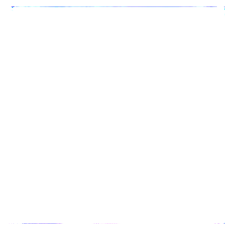

In [8]:
# latents = nd.array(T_test, ctx=gpu(0))
latents = nd.array(T_test)
net.forward(nd.expand_dims(latents[0], 0))
# print(net.collect_params('.*bias'))
net = load_weights(net)
face = face_from_latent(net, latents, '/content/mxnet/')

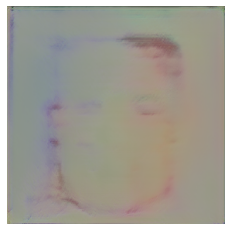

In [9]:
for i in range(len(face[0])):
    face[0][i] = (face[0][i] - face[0][i].min()) / (face[0][i].max() - face[0][i].min())

face = nd.clip(nd.rint(face * 255.0), 0.0, 255.0).astype('uint8')
face = face.transpose((0, 3, 2, 1))
if not os.path.exists('/content/test/'):
    os.mkdir('/content/test/')
save_path = os.path.join('/content/test/', 'test0.png')
image = face.asnumpy()
Image.fromarray(image[0], 'RGB').save(save_path)

img = mpimg.imread(save_path)
plt.axis('off')
plt.imshow(img)
plt.show()

In [10]:
# %tensorflow_version 1.5
# import tensorflow as tf

In [11]:
# def upscale2d(x, factor=2):
#     s = x.shape
#     x = tf.reshape(x, [-1, s[1], s[2], 1, s[3], 1])
#     x = tf.tile(x, [1, 1, 1, factor, 1, factor])
#     x = tf.reshape(x, [-1, s[1], s[2] * factor, s[3] * factor])
#     return x

In [12]:
# def lerp_clip(a, b, t): 
#     return a + (b - a) * tf.clip_by_value(t, 0.0, 1.0)

In [13]:
# lod_in = tf.cast(tf.get_variable('lod', initializer=np.float32(0.0), trainable=False), 'float32')
# lod = 7
# images_out = imgs[0]
# for i in range(1, len(imgs)):
#     img = imgs[i]
#     images_out = upscale2d(images_out)
#     images_out = lerp_clip(img.asnumpy(), images_out.asnumpy(), lod_in - lod)
#     lod -= 1

In [14]:
# plt.imshow(mpimg.imread(f"mxnet/test0.png"))
# plt.axis('off')

# f=plt.figure()
# f.add_subplot(1,2,1)
# plt.imshow(mpimg.imread(f"mxnet/test.png"))
# plt.axis('off')
# f.add_subplot(1,2,2)
# plt.imshow(mpimg.imread(f"mxnet/test2.png"))
# plt.axis('off')
# plt.show()